In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/kmontocam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kmontocam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kmontocam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kmontocam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df_ = pd.read_csv(r'data/sms_spam.csv')


In [4]:
df_.head(n=10)


,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...
5,ham,Aiya we discuss later lar... Pick u up at 4 is...
6,ham,Are you this much buzy
7,ham,Please ask mummy to call father
8,spam,Marvel Mobile Play the official Ultimate Spide...
9,ham,"fyi I'm at usf now, swing by the room whenever"


### Data Wrangling
- One hot encode
- Stemming
- Process word occurence

In [5]:
def process_text(text: str, tokenizer=RegexpTokenizer(r'[a-zA-Z]{3,}'), snow=SnowballStemmer('english'),
                 sw=stopwords.words('english')) -> str:
    tokens = tokenizer.tokenize(text)
    return ' '.join([snow.stem(word) for word in tokens
                     if word not in sw])


In [6]:
df = (
    df_
    .pipe(pd.get_dummies, columns=['type'], drop_first=True)
    .rename({'type_spam': 'spam'}, axis=1)
    .assign(text=df_.text.apply(process_text))
)


In [7]:
df.head(n=10)


,text,spam
0,hope good week just check,0
1,give back thank,0
2,also cbe but pay,0
3,complimentari star ibiza holiday cash need urg...,1
4,okmail dear dave final notic collect tenerif h...,1
5,aiya discuss later lar pick,0
6,are much buzi,0
7,pleas ask mummi call father,0
8,marvel mobil play offici ultim spider man game...,1
9,fyi usf swing room whenev,0


### Naive Bayes Model

In [8]:
class SpamClassifierNB():

    def __init__(self, df: pd.core.frame.DataFrame) -> None:

        word_counter = CountVectorizer()
        word_counts = word_counter.fit(df.text)
        # Tranform functions to manipulate text

        # Compute changes to DataFrame
        self.X = pd.DataFrame(word_counts.transform(df.text).toarray(),
                              columns=word_counts.get_feature_names_out())
        self.y = df.spam.astype(bool)

    def w_prob_spam(self) -> dict:
        """Probability of word having an occurence in text message given that
        it is spam"""
        X_spam = self.X[self.y]
        X_spam = X_spam.loc[:, X_spam.sum() > 0]
        _, n_words = X_spam.shape
        return {word: X_spam[word].astype(bool).sum()/n_words for word in X_spam}

    def w_prob_ham(self) -> dict:
        """Probability of word having an occurence in text message given that
        it is ham (not spam)"""
        X_ham = self.X[~self.y]
        X_ham = X_ham.loc[:, X_ham.sum() > 0]
        _, n_words = X_ham.shape
        return {word: X_ham[word].astype(bool).sum()/n_words for word in X_ham}

    def fit_transform(self, X_train: pd.core.frame.DataFrame, y_train: pd.core.series.Series):
        """Fit model given a sample of"""
        self.spam_probs = self.w_prob_spam()
        self.ham_probs = self.w_prob_ham()

    def process_text(self, text: str, tokenizer=RegexpTokenizer(r'[a-zA-Z]{3,}'), snow=SnowballStemmer('english'),
                     sw=stopwords.words('english')) -> list:
        tokens = tokenizer.tokenize(text)
        return [snow.stem(word) for word in tokens if word not in sw]

    def predict(self, text: str):
        spam_prob = int()
        ham_prob = int()

        for word in self.process_text(text):
            spam_prob += self.spam_probs.get(word, 0)
            ham_prob += self.ham_probs.get(word, 0)

        return spam_prob > ham_prob


### Testing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.spam,
                                                    train_size=0.7,
                                                    random_state=0)


In [10]:
classifier = SpamClassifierNB(df)
classifier.fit_transform(X_train, y_train)


In [11]:
y_pred = [classifier.predict(text) for text in X_test]
y_pred = pd.Series(y_pred, index=y_test.index).astype(int)


In [12]:
precision = precision_score(y_true=y_test.values, y_pred=y_pred)
recall = recall_score(y_true=y_test.values, y_pred=y_pred)
f1 = f1_score(y_true=y_test.values, y_pred=y_pred)
accuracy = accuracy_score(y_true=y_test.values, y_pred=y_pred)


In [13]:
print(f'{precision=:0.3f}')
print(f'{recall=:0.3f}')
print(f'{f1=:0.3f}')
print(f'{accuracy=:0.3f}')


precision=0.472
recall=0.975
f1=0.636
accuracy=0.863


In [14]:
y_true = y_test.map({0: 'Ham', 1: 'Spam'})
y_pred = y_pred.map({0: 'Ham', 1: 'Spam'})


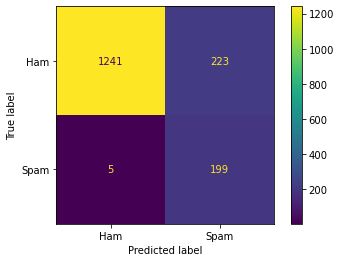

In [15]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, labels=['Ham', 'Spam']),
                           display_labels=['Ham', 'Spam']).plot()
